### Import lib

In [119]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
import scipy
import dask
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
train = pd.read_csv('taxi_fare/train.csv')
test = pd.read_csv('taxi_fare/test.csv')
submission = pd.read_csv('taxi_fare/submission.csv')

### Data Visualisation

In [3]:
# 1
train.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [4]:
train.dtypes

trip_duration         float64
distance_traveled     float64
num_of_passengers     float64
fare                  float64
tip                     int64
miscellaneous_fees    float64
total_fare            float64
surge_applied           int64
dtype: object

In [5]:
test.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0


In [6]:
test.dtypes

trip_duration         float64
distance_traveled     float64
num_of_passengers     float64
fare                    int64
tip                     int64
miscellaneous_fees    float64
total_fare              int64
surge_applied           int64
dtype: object

In [7]:
test['total_fare'].value_counts(), 

(0    89861
 Name: total_fare, dtype: int64,)

In [8]:
test['surge_applied'].value_counts(), 


(0    64495
 1    25366
 Name: surge_applied, dtype: int64,)

In [9]:
submission.head()

,total_fare
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [75]:
label_col = 'total_fare'
label_col_list = [label_col]

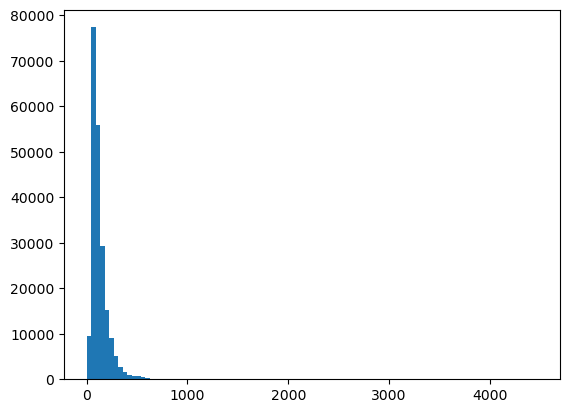

In [10]:
# 2
# Class imbalance implies classification problem, surge has 1,0 values in both train and test, submission
# indicates total_fare is the label which assumes numerical values

# looking at distribution of total_fare instead 
plt.hist(train['total_fare'], bins=100)
plt.show()

In [11]:
# imples a very high left skew
quantiles = np.quantile(train['total_fare'], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
quantiles

array([   0.  ,   70.2 ,  101.7 ,  152.25, 4472.25])

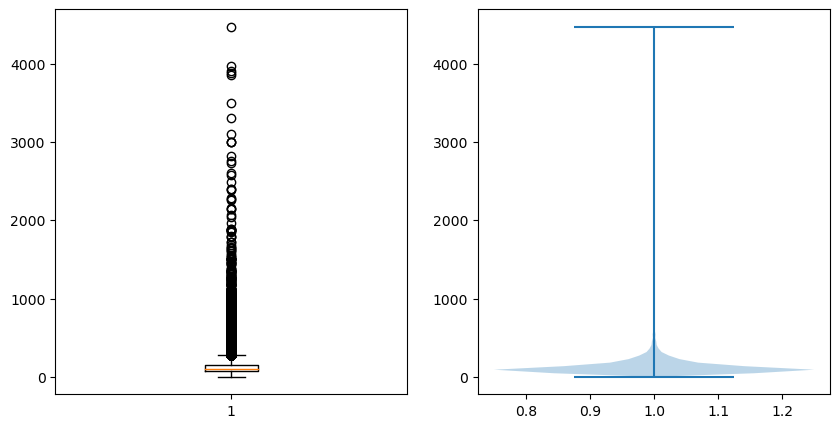

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.boxplot(train['total_fare'])

plt.subplot(1, 2, 2)
plt.violinplot(train['total_fare'])

plt.show()

In [13]:
# 3
for col in train.columns:
    if len(train[col].unique()) > 2 :
        print({col: np.quantile(train[col], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))})

{'trip_duration': array([    0.,   446.,   707.,  1098., 86387.])}
{'distance_traveled': array([2.000000e-02, 1.950000e+00, 3.200000e+00, 5.730000e+00,
       5.728391e+04])}
{'num_of_passengers': array([0., 1., 1., 1., 9.])}
{'fare': array([   0.  ,   52.5 ,   75.  ,  116.25, 4466.25])}
{'tip': array([   0.,    0.,    9.,   20., 2500.])}
{'miscellaneous_fees': array([ -0.5 ,   6.  ,   9.75,  26.45, 435.  ])}
{'total_fare': array([   0.  ,   70.2 ,  101.7 ,  152.25, 4472.25])}


In [14]:
for col in train.columns:
    if len(train[col].unique()) > 2 :
        print({col: len(train[col].unique())})

{'trip_duration': 5907}
{'distance_traveled': 2463}
{'num_of_passengers': 10}
{'fare': 631}
{'tip': 262}
{'miscellaneous_fees': 1674}
{'total_fare': 3742}


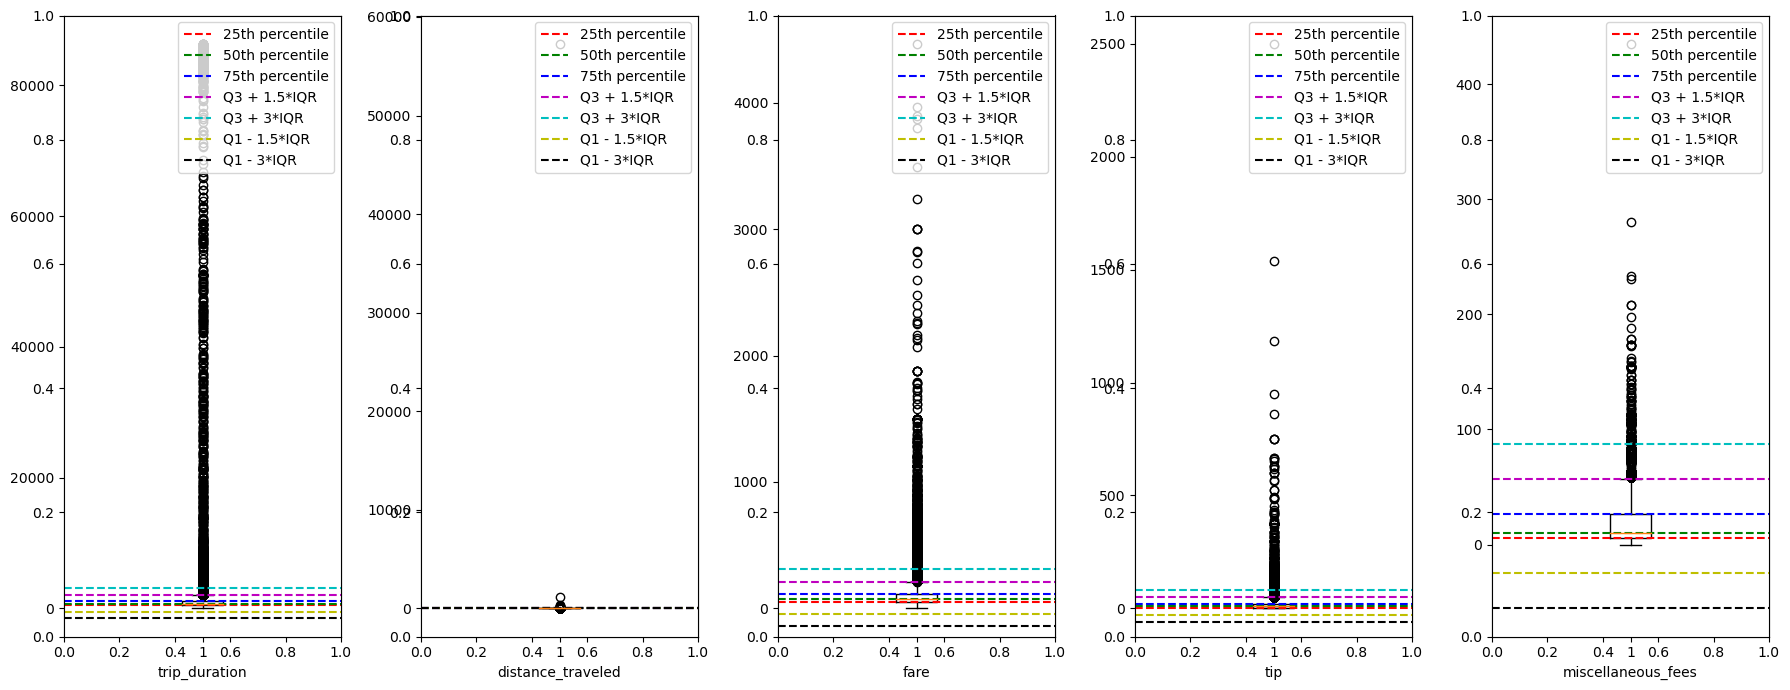

In [15]:
num_cols = ['trip_duration', 'distance_traveled', 'fare', 'tip', 'miscellaneous_fees']


def plot_boxplot(train_df, num_col_list, fig_size=None):
    train = train_df
    quantiles = [25, 50, 75]
    colors = ['r', 'g', 'b']
    linestyles = ['--', '--', '--']
    labels = [f'{q}th percentile' for q in quantiles]

    fig, axs = plt.subplots(1, len(num_col_list), figsize=(18, 7) if fig_size is None else fig_size)

    for i, column in enumerate(num_col_list):
        ax = fig.add_subplot(1, len(num_col_list), i+1)
        ax.boxplot(train[column])
        ax.set_xlabel(column)
        column_quantiles = np.percentile(train[column], quantiles)

        # Add lines for quartiles
        for quantile, color, linestyle, label in zip(column_quantiles, colors, linestyles, labels):
            ax.axhline(quantile, color=color, linestyle=linestyle, label=label)

        # Calculate IQR (Interquartile Range)
        Q1 = column_quantiles[0]
        Q3 = column_quantiles[2]
        IQR = Q3 - Q1

        # Add lines for outlier detection
        upper_line1 = Q3 + 1.5 * IQR
        upper_line2 = Q3 + 3 * IQR
        lower_line1 = Q1 - 1.5 * IQR
        lower_line2 = Q1 - 3 * IQR

        ax.axhline(upper_line1, color='m', linestyle='--', label='Q3 + 1.5*IQR')
        ax.axhline(upper_line2, color='c', linestyle='--', label='Q3 + 3*IQR')
        ax.axhline(lower_line1, color='y', linestyle='--', label='Q1 - 1.5*IQR')
        ax.axhline(lower_line2, color='k', linestyle='--', label='Q1 - 3*IQR')

        ax.legend(loc= 'upper right')

    plt.tight_layout()
    plt.show()

plot_boxplot(train, num_cols)


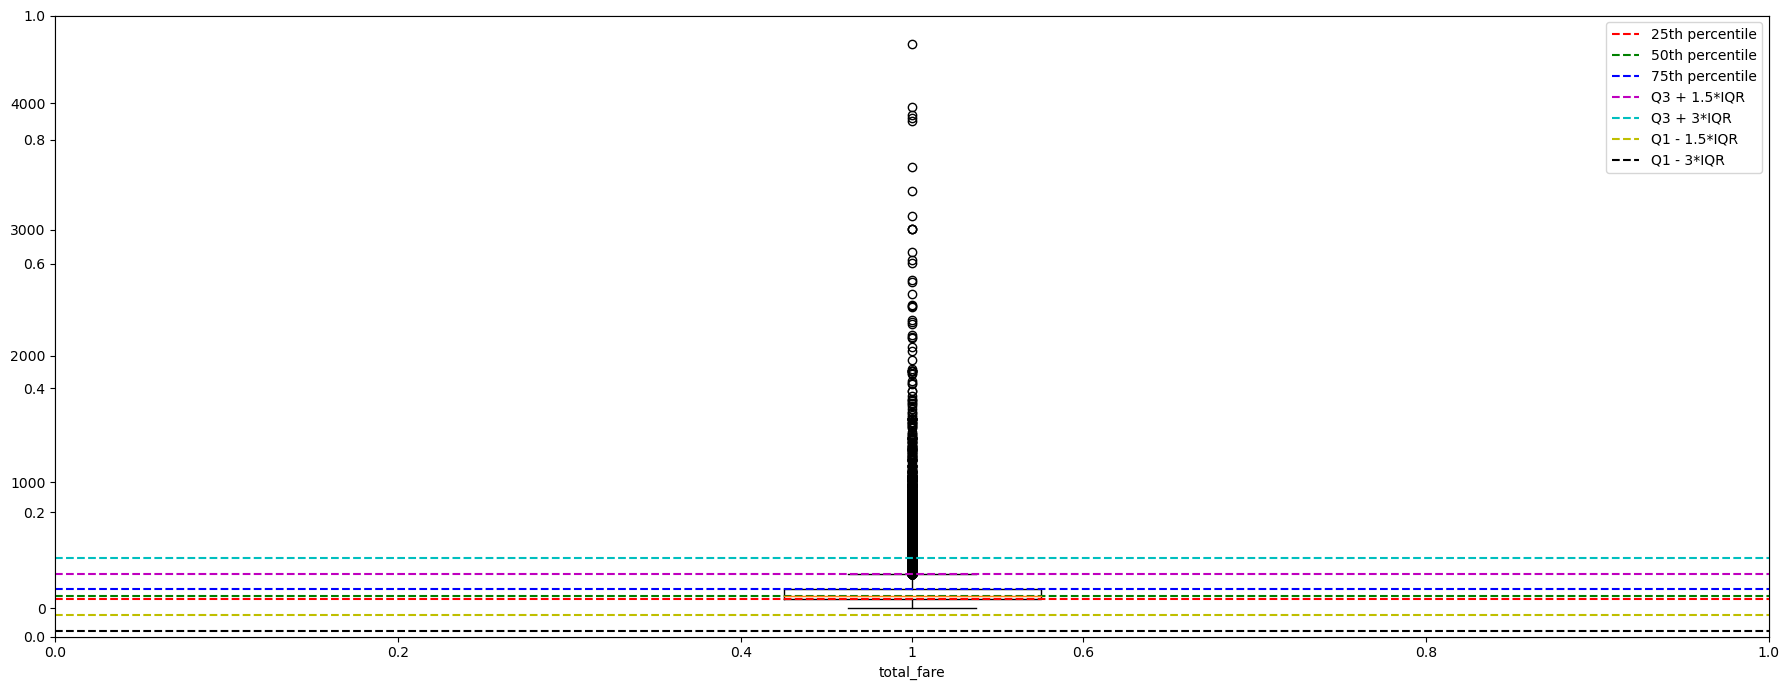

In [16]:
# distribution of labels:
plot_boxplot(train, ['total_fare'])

0    150855
1     58818
Name: surge_applied, dtype: int64


1.0    179229
2.0     17896
5.0      4713
6.0      3382
3.0      2757
4.0       908
0.0       753
8.0        25
9.0         8
7.0         2
Name: num_of_passengers, dtype: int64




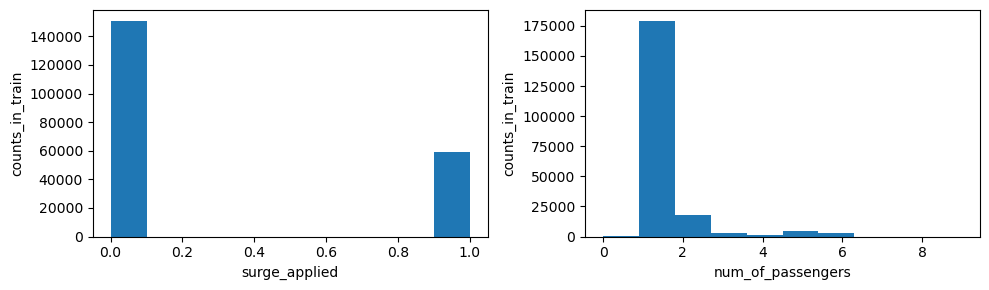

In [67]:
cat_col = ['surge_applied', 'num_of_passengers']
for col in cat_col:
    print(train[col].value_counts())
    print('\n')
    
def plot_hist(train_df, cat_col, fig_size=None):
    plt.figure(figsize=(10, 3) if fig_size is None else fig_size)
    for i, col in enumerate(cat_col, start=1):
        plt.subplot(1,len(cat_col),i)
        plt.hist(train_df[col])
        plt.xlabel(col)
        plt.ylabel('counts_in_train')
    plt.tight_layout()
    plt.show()
    return
    
plot_hist(train, cat_col)

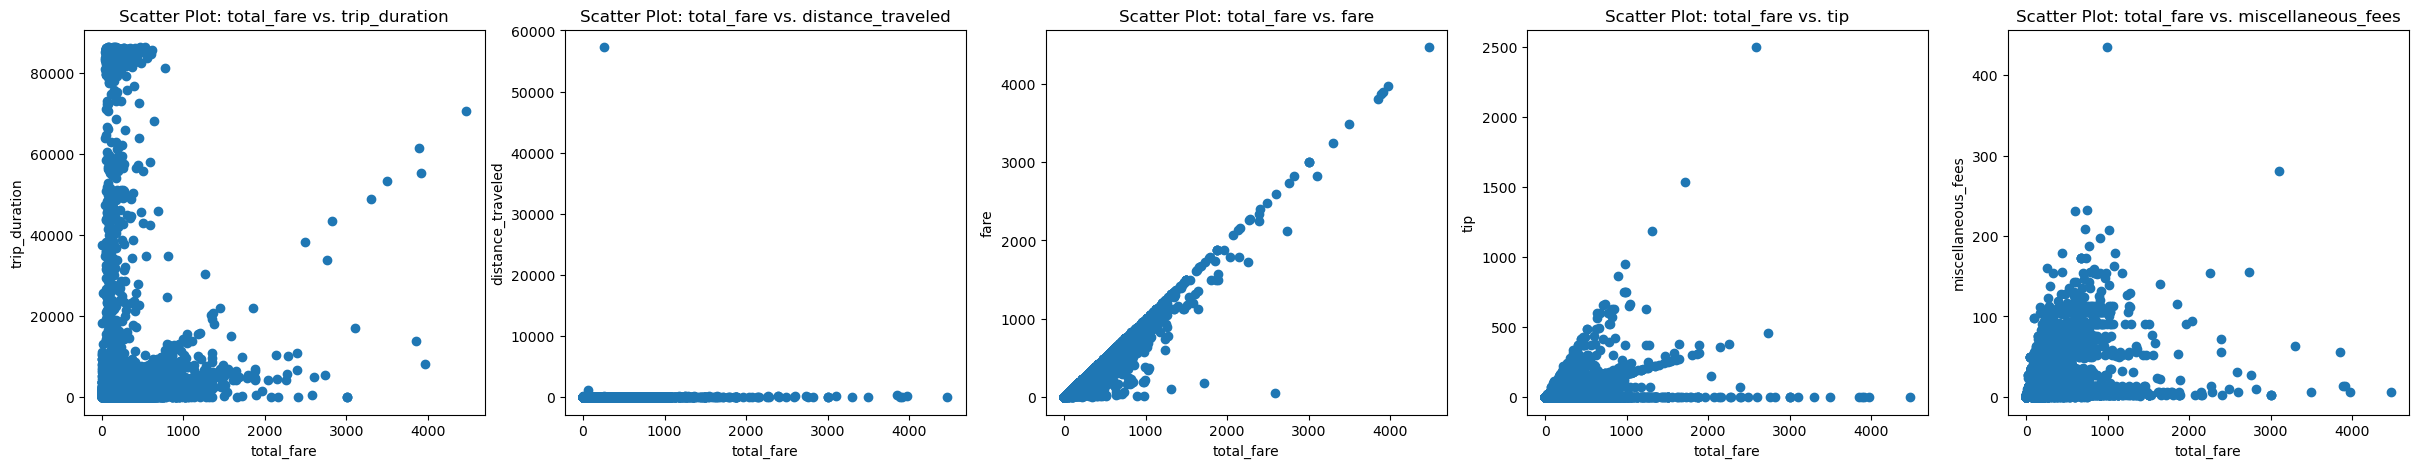

In [18]:
# 3, 5 

# realationship of features with label
# numerical
plt.figure(figsize=(30,5))
for i, col in enumerate(num_cols, start=1):
    plt.subplot(1, 5, i)
    plt.scatter(train['total_fare'], train[col])
    plt.ylabel(col)
    plt.xlabel('total_fare')
    plt.title(f'Scatter Plot: total_fare vs. {col}')
plt.show()
    

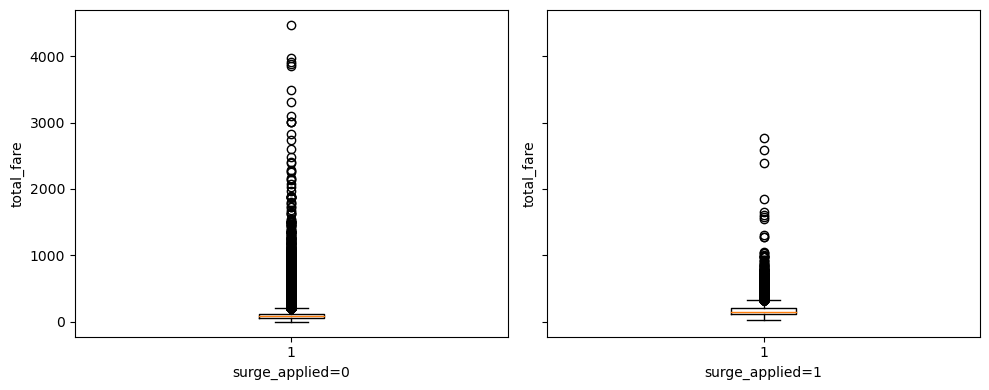

In [19]:
# categorical
col_1 = cat_col[0]
categories_1 = train[col_1].unique()

# Create subplots using plt.subplots
fig, axes = plt.subplots(1, len(categories_1), figsize=(10, 4), sharey=True)

# Iterate over each category of col_1
for i, cat_1 in enumerate(categories_1):
    # Select data points with matching category
    data = train[train[col_1] == cat_1]
    
    # Plot boxplot of numerical label
    axes[i].boxplot(data['total_fare'])
    axes[i].set_xlabel(f'{col_1}={cat_1}')
    axes[i].set_ylabel('total_fare')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


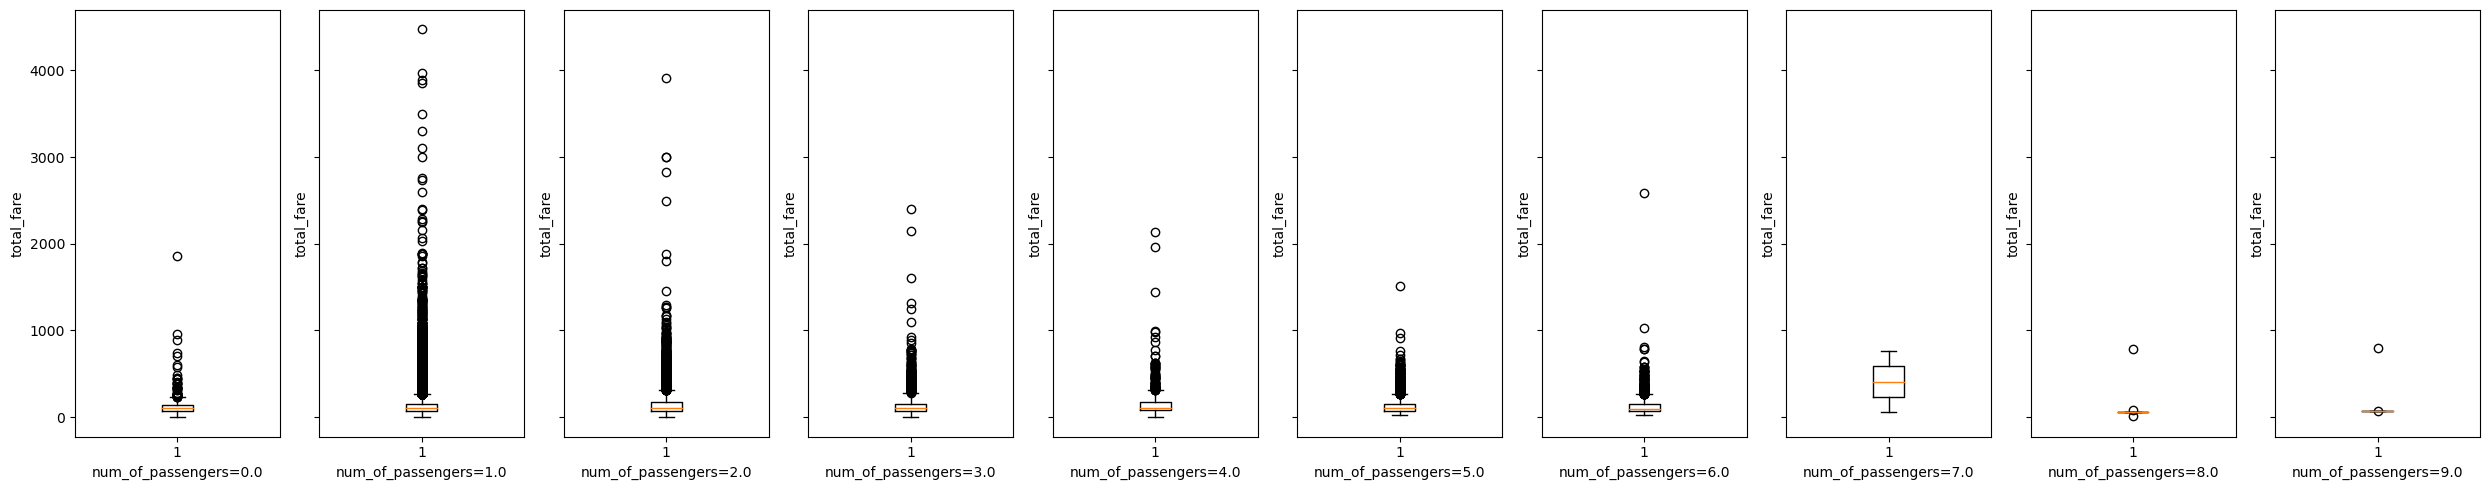

In [20]:
col_1 = cat_col[1]
categories_1 = train[col_1].unique()

# Create subplots using plt.subplots
fig, axes = plt.subplots(1, len(categories_1), figsize=(25, 5), sharey=True)

# Iterate over each category of col_1
for i, cat_1 in enumerate(sorted(categories_1)):
    # Select data points with matching category
    data = train[train[col_1] == cat_1]
    
    # Plot boxplot of numerical label
    axes[i].boxplot(data['total_fare'])
    axes[i].set_xlabel(f'{col_1}={cat_1}')
    axes[i].set_ylabel('total_fare')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


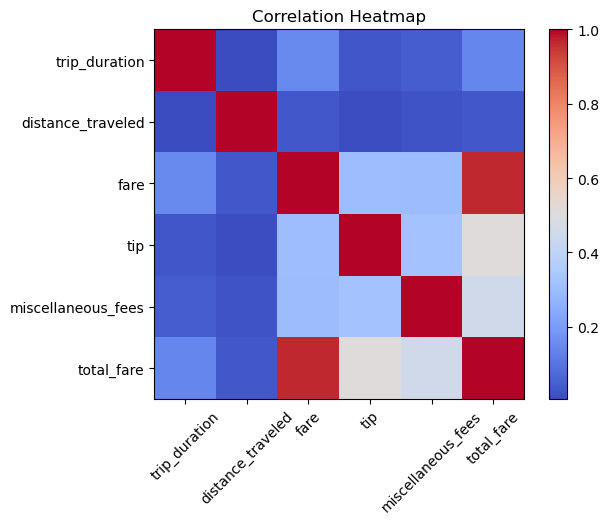

In [21]:
# 4 
# correlation check
col_list = num_cols + ['total_fare']
correlation_matrix = train[col_list].corr()

fig, ax = plt.subplots()
heatmap = ax.imshow(correlation_matrix, cmap='coolwarm')

ax.set_xticks(np.arange(len(col_list)))
ax.set_yticks(np.arange(len(col_list)))
ax.set_xticklabels(col_list)
ax.set_yticklabels(col_list)

plt.xticks(rotation=45)
cbar = plt.colorbar(heatmap)
plt.title('Correlation Heatmap')
plt.show()


From here it can be seen that fare and total_fare are highly corrrlated (0.967). rest features dont show high correlation
with each other or label, tip comes closest. Correlation among features is less than 0.8 in all cases, we dont need to drop anything.

In [22]:
correlation_matrix

,trip_duration,distance_traveled,fare,tip,miscellaneous_fees,total_fare
trip_duration,1.000000,0.005774,0.150331,0.029132,0.046432,0.142159
distance_traveled,0.005774,1.000000,0.035934,0.013487,0.021734,0.036677
fare,0.150331,0.035934,1.000000,0.302044,0.299321,0.966748
tip,0.029132,0.013487,0.302044,1.000000,0.320919,0.508639
miscellaneous_fees,0.046432,0.021734,0.299321,0.320919,1.000000,0.452568
total_fare,0.142159,0.036677,0.966748,0.508639,0.452568,1.000000


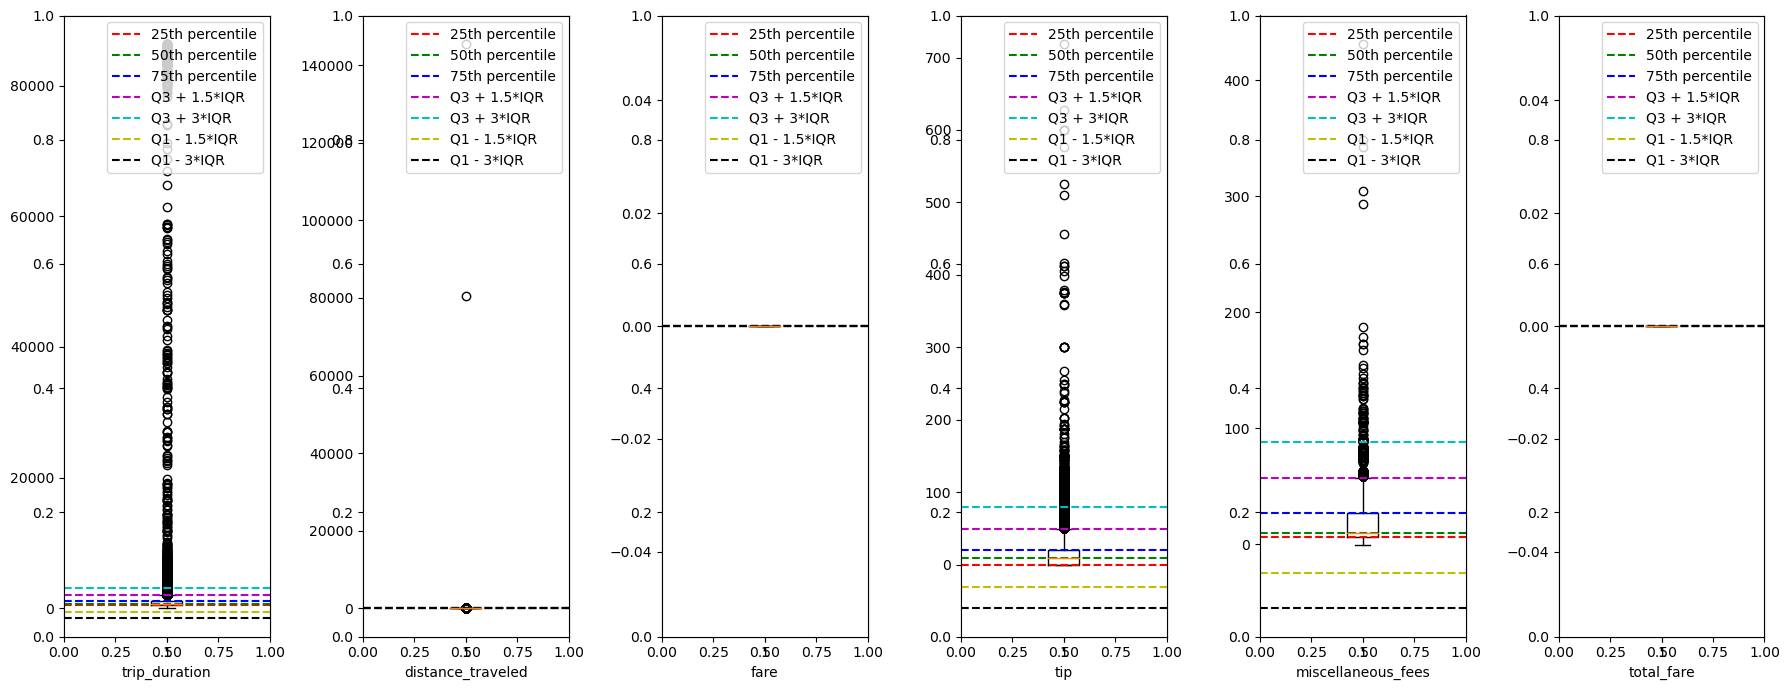

In [74]:
# Looking at test data characterstics
plot_boxplot(test, num_cols+label_col_list)

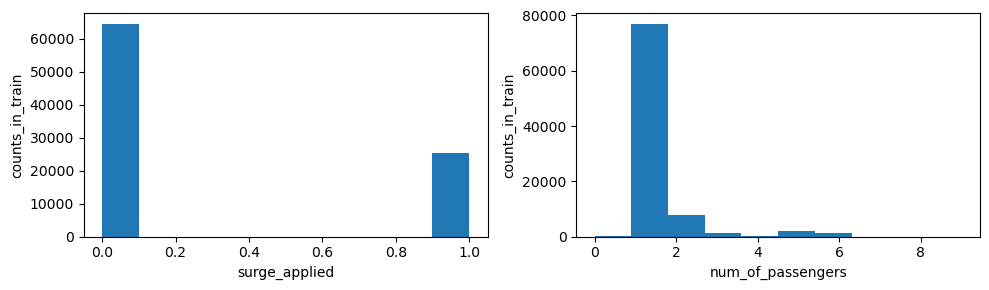

In [76]:
plot_hist(test, cat_col)

### IMPORTANT: Fare, like total fare assumes only zero values in test but has high correlation with label in train

Therefore this column must be dropped because it adversely effects predictions.

In [78]:
train.drop('fare', axis=1, inplace=True)
test.drop('fare', axis=1, inplace=True)
num_cols.remove('fare')

### Data Pre-processing

Steps involved: 
1. scaling numerical features and labels
2. Removing minor and major outliers from train

In [82]:
#1.1 Check presence of null value
print(train.isna().sum())
print('\n')
test.isna().sum()


trip_duration         0
distance_traveled     0
num_of_passengers     0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64




trip_duration         0
distance_traveled     0
num_of_passengers     0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

#2 Handle skewness As we data is left skewed for all the variables , we can apply log transformation or BoxCox transformation 
to handle skweness , we'll use BoxCox here as it performs better than Natural Log transformation and works best when we have both positive and negative values as we can see in miscellaneous_fees

In [83]:
num_cols

['trip_duration', 'distance_traveled', 'tip', 'miscellaneous_fees']

In [150]:
#1.2 log transformation of features and label
d_train=train.copy()

# Log transformation
d_train['trip_duration'] = np.log1p(train['trip_duration'])
d_train['distance_traveled'] = np.log1p(train['distance_traveled'])
# d_train['fare'] = np.log1p(train['fare'])
d_train['tip'] = np.log1p(train['tip'])
d_train['miscellaneous_fees'] = np.log1p(train['miscellaneous_fees'])

# Transforming labels
# d_train['total_fare'] = np.log1p(train['total_fare'])

In [151]:
d_train.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,total_fare,surge_applied
0,6.618739,1.321756,1.0,3.218876,1.987874,105.300,0
1,7.080026,1.488400,1.0,3.218876,2.653242,142.200,0
2,6.594413,1.415853,1.0,0.000000,3.318721,97.875,1
3,6.510258,1.891605,3.0,0.000000,2.374906,99.750,0
4,5.799093,1.128171,1.0,2.564949,2.653242,70.200,0


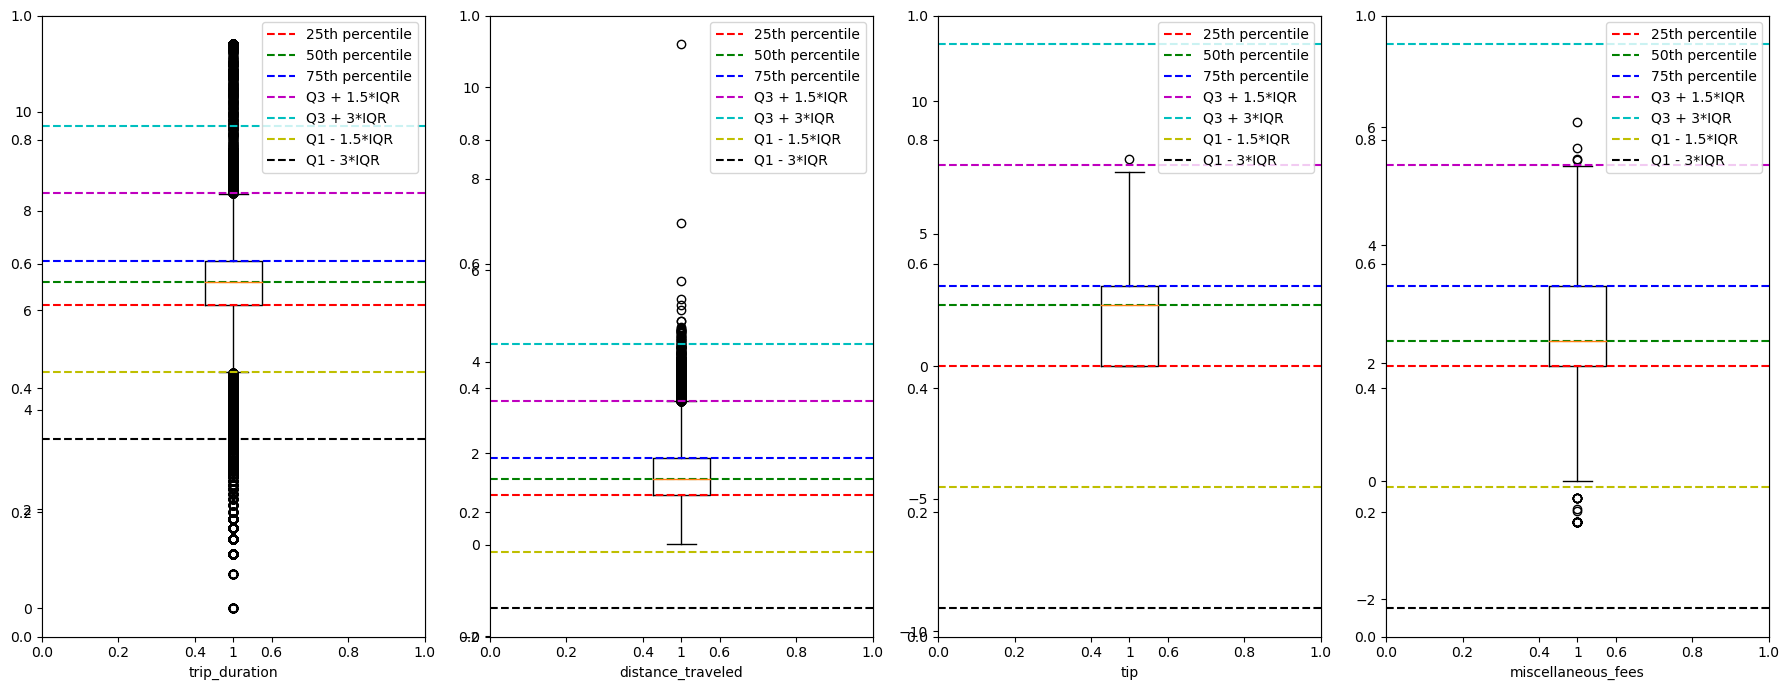

In [152]:
# distrubition of scaled features
plot_boxplot(d_train, num_cols)

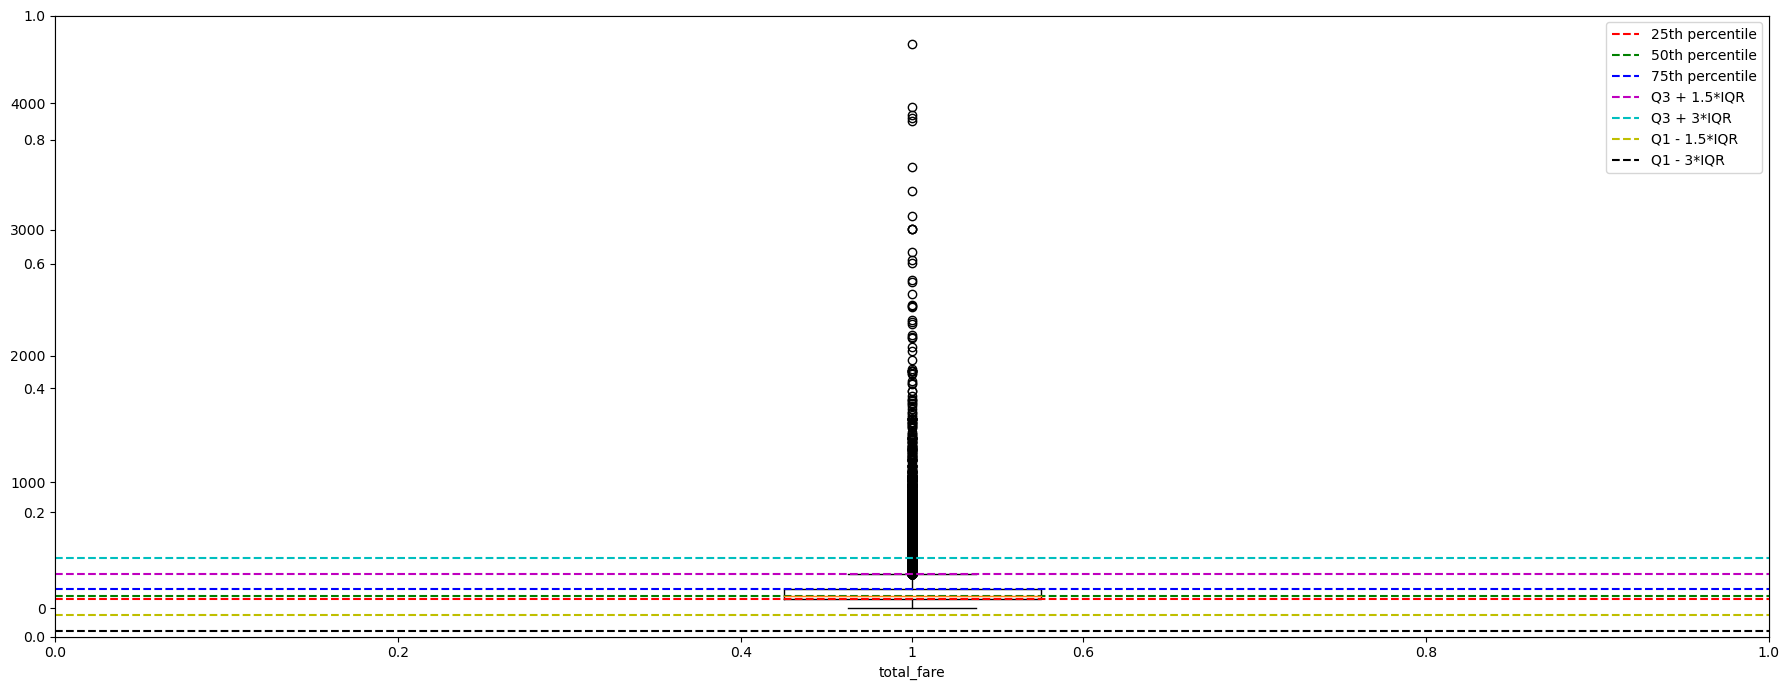

In [154]:
# distrubition of scaled label
plot_boxplot(d_train, ['total_fare'])
# final predictions requre exp(pred) -1 as op

There dont seem to be a lot of data points with features or label == 0. So we dont need to seperately handel that


In [159]:
# 1.3: Removing minor outliers in label present even after log transformation. 
# Since we are fitting a linear regressor, we dont want to fit a straight line on few extremely large/small outliers

Q1 = d_train['total_fare'].quantile(0.25)
Q3 = d_train['total_fare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Scaled label properties: ', Q1, Q3, IQR, (lower_bound, upper_bound), 
      (min(d_train['total_fare']), max(d_train['total_fare'])))
d_train['is_label_outlier'] = np.where(((d_train['total_fare'] < lower_bound) | (d_train['total_fare'] > upper_bound)), 1, 0)

d_train['is_label_outlier'].value_counts()

Scaled label properties:  70.19999999999999 152.25 82.05000000000001 (-52.87500000000003, 275.32500000000005) (0.0, 4472.25)


0    197490
1     12183
Name: is_label_outlier, dtype: int64

In [160]:
12183/(197490+12183)*100 # 6% data is minor outliers, can drop these

5.810476313116138

In [161]:
d_train1 = d_train[d_train['is_label_outlier']==0].copy()
d_train1.drop('is_label_outlier', axis=1, inplace=True)
print(d_train1.shape, train.shape , abs(d_train1.shape[0] -  train.shape[0]))
d_train1.head()

(197490, 7) (209673, 7) 12183


,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,total_fare,surge_applied
0,6.618739,1.321756,1.0,3.218876,1.987874,105.300,0
1,7.080026,1.488400,1.0,3.218876,2.653242,142.200,0
2,6.594413,1.415853,1.0,0.000000,3.318721,97.875,1
3,6.510258,1.891605,3.0,0.000000,2.374906,99.750,0
4,5.799093,1.128171,1.0,2.564949,2.653242,70.200,0


##### As both train and test have 1,0 values of surge applied, with similar event rates too,
#### THIS IS NOT A CLASSIFICATION PROBLEM. So no concept of class imbalance holds

In [164]:
train['surge_applied'].value_counts(), test['surge_applied'].value_counts()
58818/150855, 25366/64495

(0.3898975837724968, 0.39330180634157685)

In [165]:
d_train1[label_col].describe()

count    197490.000000
mean        110.754329
std          54.342672
min           0.000000
25%          69.750000
50%          97.200000
75%         139.950000
max         275.250000
Name: total_fare, dtype: float64

#### Normalization:We can use Min-Max scaling method. 

It scales the values in each feature to a fixed range, typically between 0 and 1. This normalization technique preserves the relative relationships between the data points

This also makes the coefficients in linear model directly comparable, since all features range between 0 and 1,
Which can later be used to figureout important features

In [166]:
X= d_train1.drop('total_fare', axis=1)
y= d_train1['total_fare']
print(y.shape)
X.head()

(197490,)


,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,6.618739,1.321756,1.0,3.218876,1.987874,0
1,7.080026,1.488400,1.0,3.218876,2.653242,0
2,6.594413,1.415853,1.0,0.000000,3.318721,1
3,6.510258,1.891605,3.0,0.000000,2.374906,0
4,5.799093,1.128171,1.0,2.564949,2.653242,0


##### Num_passengers is already ordinal encoded and surge_applied has two distinct values {0,1} so its nominal encoded
Applying minmax sclaer to num_passengers makes weights compareable and dosent affect inherent order of passenger numbers,
and has virtually no affect on surge_applied. Therefore we directly apply it to all features.


In [167]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
train_normalized = scaler.fit_transform(X)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Convert the normalized data back to a dataframe
X_scaled=  pd.DataFrame(train_normalized, columns=X.columns)
print(X_scaled.shape, y.shape)
# Check the normalized dataframe
X_scaled.head()


(197490, 6) (197490,)


,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,0.582299,0.119052,0.111111,0.586430,0.464407,0.0
1,0.622882,0.134290,0.111111,0.586430,0.579662,0.0
2,0.580159,0.127657,0.111111,0.000000,0.694937,1.0
3,0.572755,0.171160,0.333333,0.000000,0.531449,0.0
4,0.510188,0.101351,0.111111,0.467294,0.579662,0.0


#### Similar preprocessing for Test data

In [169]:
d_test=test.copy()

# Log transformation
d_test['trip_duration'] = np.log1p(d_test['trip_duration'])
d_test['distance_traveled'] = np.log1p(d_test['distance_traveled'])
# d_test['fare'] = np.log1p(d_test['fare'])
d_test['tip'] = np.log1p(d_test['tip'])
d_test['miscellaneous_fees'] = np.log1p(d_test['miscellaneous_fees'])


X_test= d_test.drop('total_fare', axis=1)
y_test = np.log1p(d_test['total_fare'])

test_normalized = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(test_normalized, columns=X_test.columns)
print(X_test_scaled.shape, test.shape, y_test_unscaled.shape)
X_test_scaled.head()

(89861, 6) (89861, 7) (89861,)


,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,surge_applied
0,0.614252,0.148592,0.111111,0.000000,0.583284,0.0
1,0.533475,0.081241,0.444444,0.000000,0.583284,0.0
2,0.594149,0.148061,0.111111,0.586430,0.457138,0.0
3,0.566094,0.129849,0.111111,0.505123,0.447601,0.0
4,0.548141,0.144992,0.111111,0.000000,0.324234,0.0



## 3. Model Building


In [173]:
# 3.1 train test splits. 
# train and test was predivided, checking sizes
print('existing test size: ', test.shape[0]/(train.shape[0] + test.shape[0]))

# 70-30 train test split is already done for us. 

# Also, since test has no labels, we cant do a 80-20 split. 
y_test.value_counts()

existing test size:  0.30000267081533316


0.0    89861
Name: total_fare, dtype: int64

## We cant find test mse in this case because we do not have existing test labels. 

Only train metrics can be looked at in this case

In [174]:

# 3.2 Cross validation
# Using gridsearchCV for this, it takes all paramters in grid, performs CV and gives best estimate for our model.


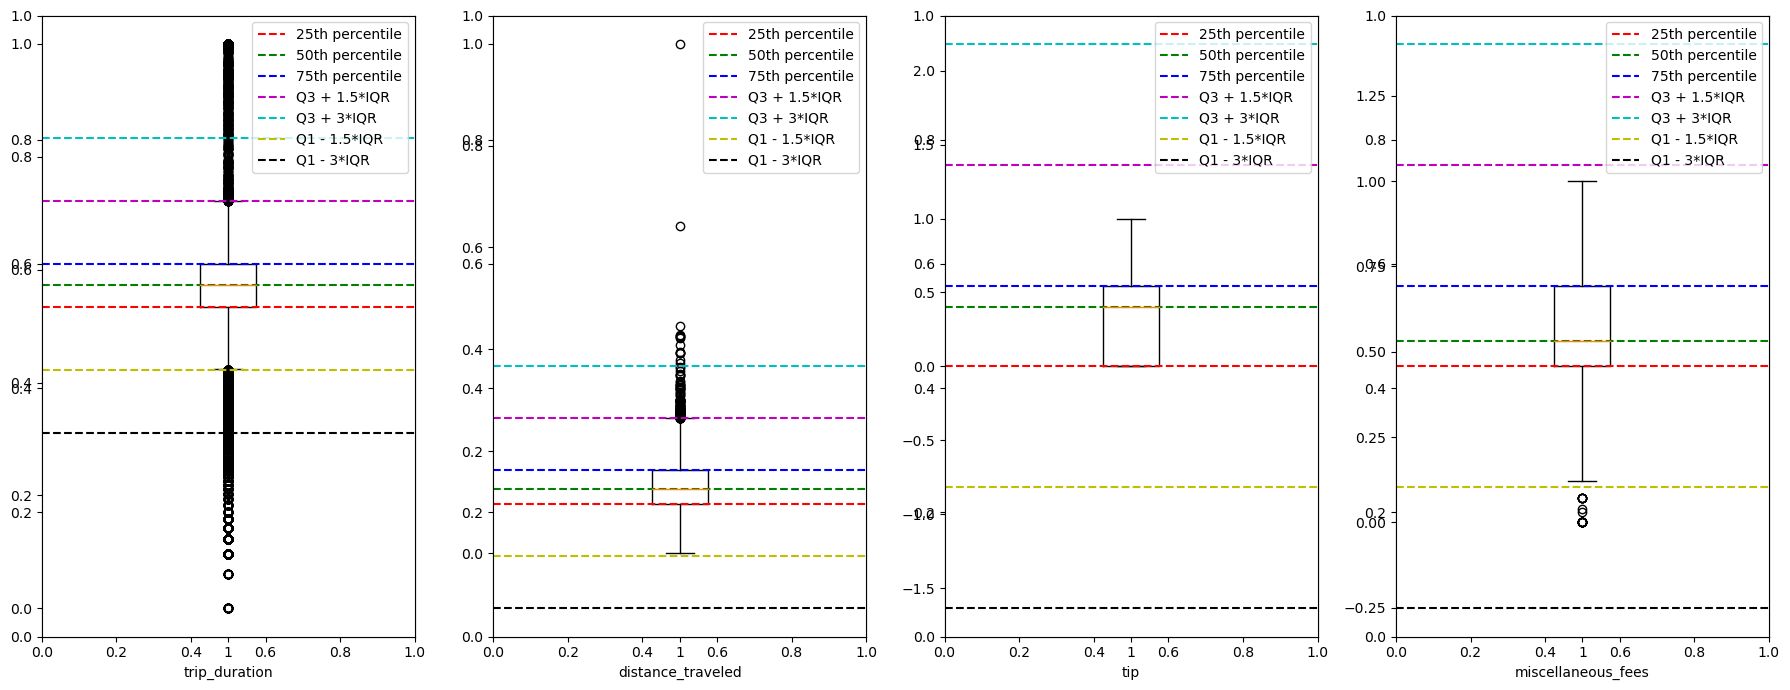

In [175]:
# final check on feature and label distribution
plot_boxplot(X_scaled, num_cols)

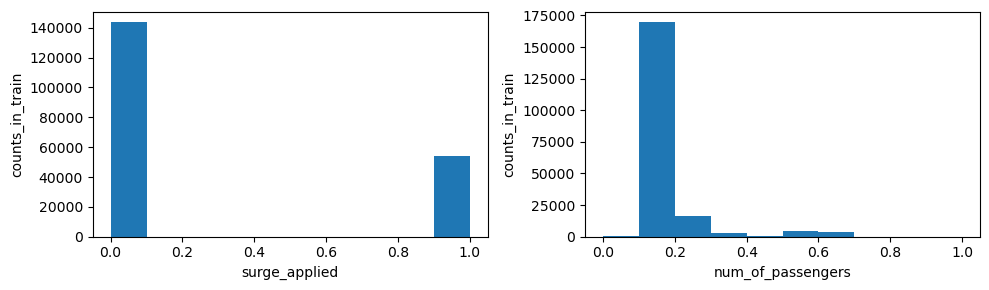

In [176]:
plot_hist(X_scaled, cat_col)

<Axes: >

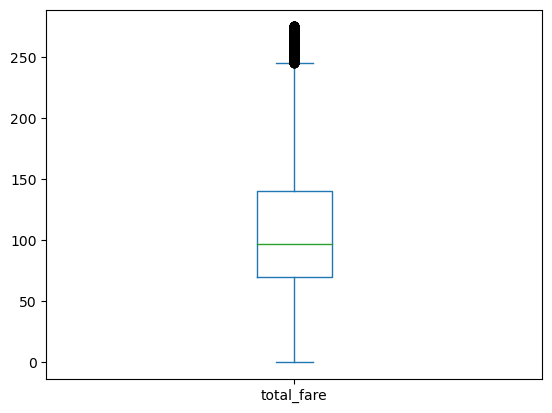

In [177]:
y.plot.box()

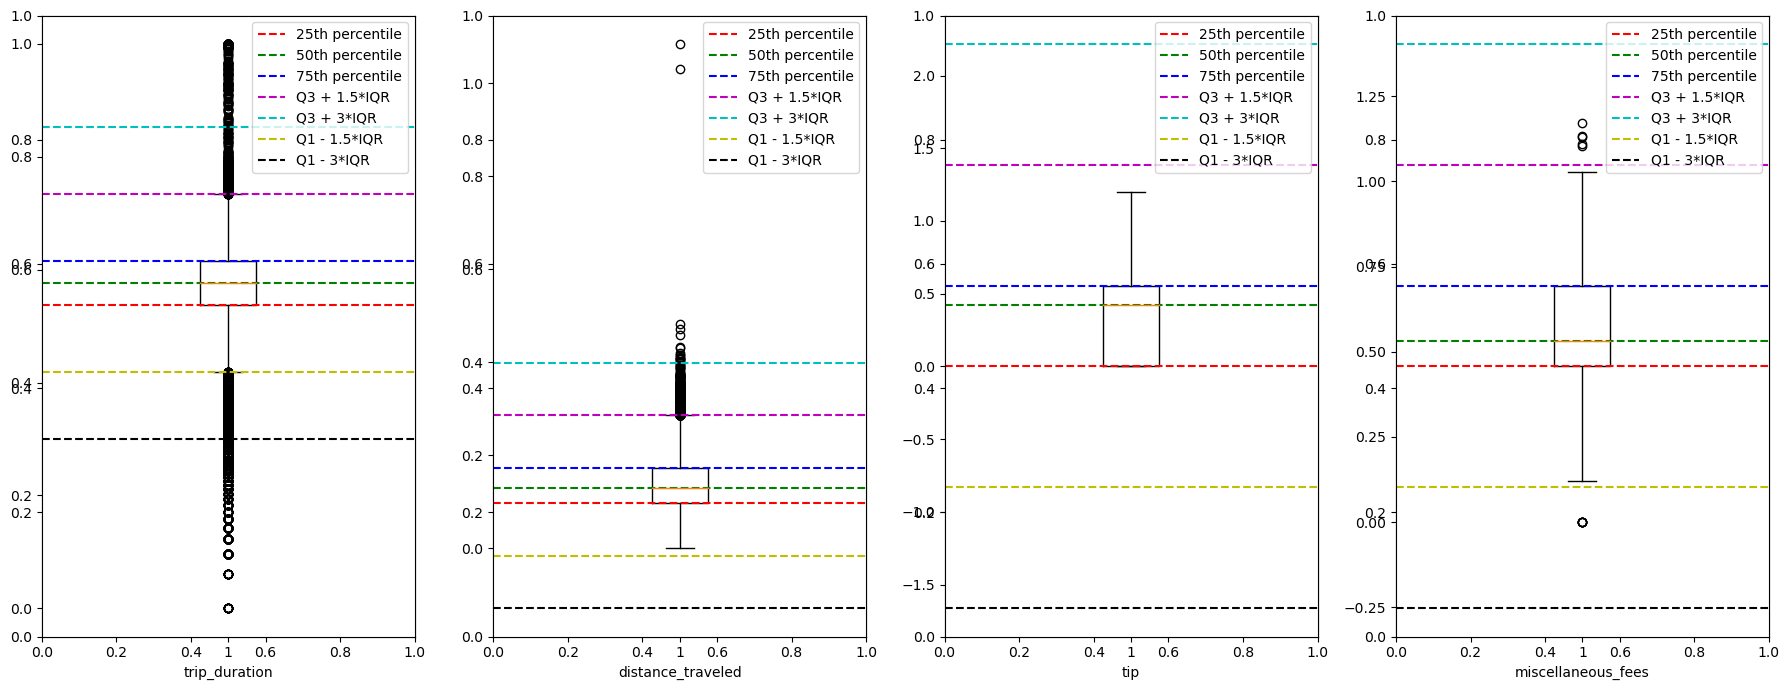

In [178]:
plot_boxplot(X_test_scaled, num_cols)

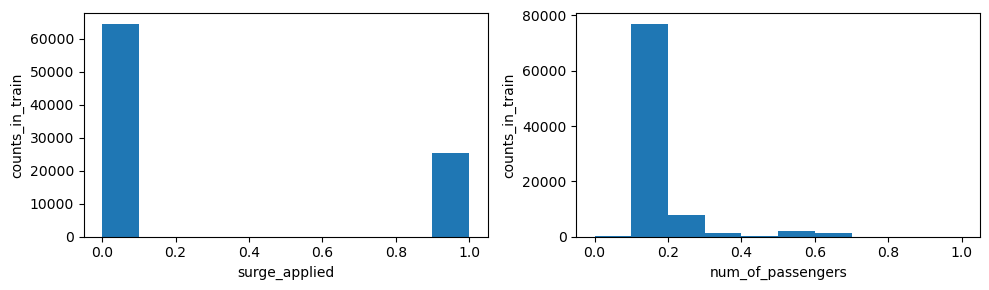

In [179]:
plot_hist(X_test_scaled, cat_col)

In [104]:
# everything looks okay, begining with defining parameter dict 

In [180]:
param_grid = {
    'fit_intercept': [True, False]
}

Since there are no hyperparametrers in traditional lr to tune, cv dosent achives much.

In [181]:
# 3.2 5-fold cross validation
init = time.time()
np.random.seed(100)
model = LinearRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=['neg_root_mean_squared_error', 'r2'],
                           refit='r2', verbose=4)

grid_search.fit(X_scaled, y)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('best_params: ', best_params)
print('best_score: ', best_score)

best_model = grid_search.best_estimator_
best_weights = best_model.coef_

print("Best Model Weights:", *dict(zip(X_scaled.columns, best_weights)).items(), sep='\n')

time.time() - init

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END fit_intercept=True; neg_root_mean_squared_error: (test=-23.393) r2: (test=0.814) total time=   0.0s
[CV 2/5] END fit_intercept=True; neg_root_mean_squared_error: (test=-24.005) r2: (test=0.806) total time=   0.0s
[CV 3/5] END fit_intercept=True; neg_root_mean_squared_error: (test=-23.146) r2: (test=0.820) total time=   0.0s
[CV 4/5] END fit_intercept=True; neg_root_mean_squared_error: (test=-23.741) r2: (test=0.810) total time=   0.0s
[CV 5/5] END fit_intercept=True; neg_root_mean_squared_error: (test=-24.267) r2: (test=0.797) total time=   0.0s
[CV 1/5] END fit_intercept=False; neg_root_mean_squared_error: (test=-23.627) r2: (test=0.810) total time=   0.0s
[CV 2/5] END fit_intercept=False; neg_root_mean_squared_error: (test=-24.206) r2: (test=0.803) total time=   0.0s
[CV 3/5] END fit_intercept=False; neg_root_mean_squared_error: (test=-23.441) r2: (test=0.815) total time=   0.0s
[CV 4/5] END fit_intercept=False;

0.49975061416625977

Might try lasso regressor since some weights are very high. 

Training with negative rmse and r2, refit on all data using r2. 0.85 of all variance in label is captured by our variable,
This looks great since its higher than general benchmark of 0.8


In [182]:
# 3.3 Training Linear regression
final_model = LinearRegression(**best_params)
final_model.fit(X_scaled, y)
y_pred = final_model.predict(X_scaled)
y_pred.shape, min(y_pred), max(y_pred), min(y), max(y)

((197490,), -31.361658358774296, 827.5647407027509, 0.0, 275.25)

In [183]:
# 2. Performance measure

Since we only have labels for train data, we can only measure performance for train. <br>
We get rmse, mae and r2 score from our model train predictions <br>
But the labels were scaled. So we scale back and again find these metrics

In [184]:
# on log transformed labels and predictions
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(' rmse: ', rmse, '\n', 'mae: ', mae, '\n', 'r2 score: ', r2)

 rmse:  23.70999263978999 
 mae:  15.412296479714929 
 r2 score:  0.8096367745609021


R2 of 0.81 implies predictions are pretty good

In [185]:
y_test_pred = final_model.predict(X_test_scaled)
y_test_pred.shape, min(y_test_pred), max(y_test_pred)

((89861,), -30.991953443248047, 912.0928988634194)

Since we do not have train labels we can look at distribution of scores in train and test, esp mean median etc

#### Assuming random sampling from same population and that both train and test are representatives of original sample, these metrics should come out to be similar

<Axes: >

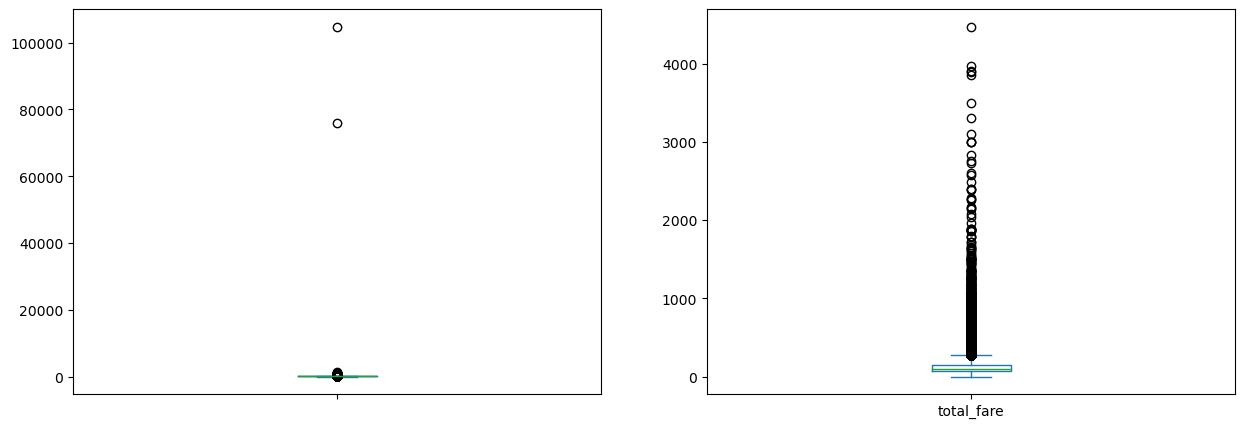

In [188]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
pd.Series(y_test_pred1).plot.box()
plt.subplot(1,2,2)
train[label_col].plot.box()


In [194]:
print('Test predicted statistics')
print(pd.Series(y_test_pred).describe())
print('\n')
print('Train statistics')
print(train[label_col].describe())

Test predicted statistics
count    89861.000000
mean       117.131256
std         55.700555
min        -30.991953
25%         77.067449
50%        109.993774
75%        153.700872
max        912.092899
dtype: float64


Train statistics
count    209673.000000
mean        127.791084
std          98.797374
min           0.000000
25%          70.200000
50%         101.700000
75%         152.250000
max        4472.250000
Name: total_fare, dtype: float64


Mean median and std of test indeed look similar to train, implying optimitic predictions. <br>
R2 score of our model is 0.81 which is also quite good ( > benchmark 0.8) <br>
We can finalise this model